* Name: Sudhir Sharma
* Roll Number: 12041500






In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import itertools
import pandas as pd
import numpy as np
import os
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [ ]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [ ]:
data.head

<bound method NDFrame.head of                     Open          High           Low         Close  \
Date                                                                 
2007-09-17   4518.450195   4549.049805   4482.850098   4494.649902   
2007-09-18   4494.100098   4551.799805   4481.549805   4546.200195   
2007-09-19   4550.250000   4739.000000   4550.250000   4732.350098   
2007-09-20   4734.850098   4760.850098   4721.149902   4747.549805   
2007-09-21   4752.950195   4855.700195   4733.700195   4837.549805   
...                  ...           ...           ...           ...   
2022-10-14  17322.300781  17348.550781  17169.750000  17185.699219   
2022-10-17  17144.800781  17328.550781  17098.550781  17311.800781   
2022-10-18  17438.750000  17527.800781  17434.050781  17486.949219   
2022-10-19  17568.150391  17607.599609  17472.849609  17512.250000   
2022-10-20  17423.099609  17584.150391  17421.000000  17563.949219   

               Adj Close  Volume       Date  
Date         

# Functions

In [ ]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [ ]:
def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [ ]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid 


<AxesSubplot:>

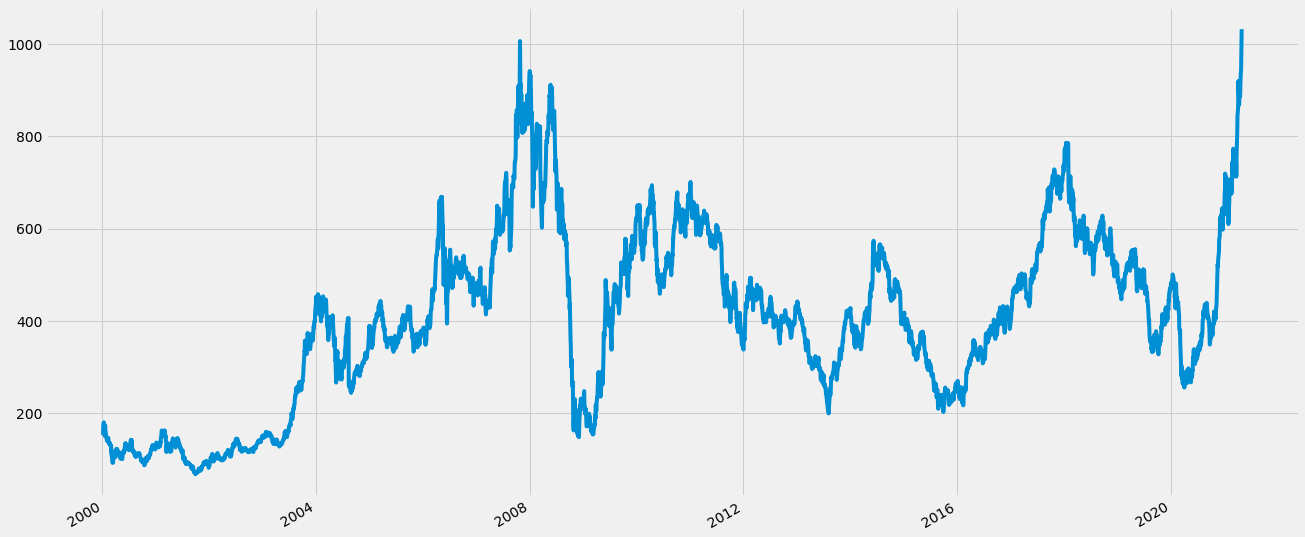

In [ ]:
# load the dataset
stock_name = 'TATASTEEL'

df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')

In [ ]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [ ]:
# use 50 historical observations, predict 1 step ahead
look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)


(5255, 50) (5255, 1)


Our `prepare_split` function takes care of reshaping the data into `[batch size, time steps, dimensionality]`

In [ ]:

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)


(5000, 50, 1) (255, 50, 1) (5000, 1) (255, 1)


In [ ]:
def create_model1():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model1 = create_model1()


2022-10-23 22:28:27.825129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 22:28:27.958753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 22:28:27.959529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 22:28:27.960630: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

2022-10-23 22:28:31.035517: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
313/313 [==============================] - 12s 32ms/step - loss: 0.0313 - val_loss: 0.0035
Epoch 2/6
313/313 [==============================] - 10s 32ms/step - loss: 6.6435e-04 - val_loss: 0.0011
Epoch 3/6
313/313 [==============================] - 11s 35ms/step - loss: 4.0932e-04 - val_loss: 8.2792e-04
Epoch 4/6
313/313 [==============================] - 10s 32ms/step - loss: 3.4386e-04 - val_loss: 6.5722e-04
Epoch 5/6
313/313 [==============================] - 10s 32ms/step - loss: 3.0761e-04 - val_loss: 6.3755e-04
Epoch 6/6
313/313 [==============================] - 11s 35ms/step - loss: 2.8359e-04 - val_loss: 5.5208e-04


In [ ]:
# predict and calculate RMSE
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)


In [ ]:
print('RMSE: ' + str(my_rmse(y_pred1, yvalid1)))

RMSE: 22.6501


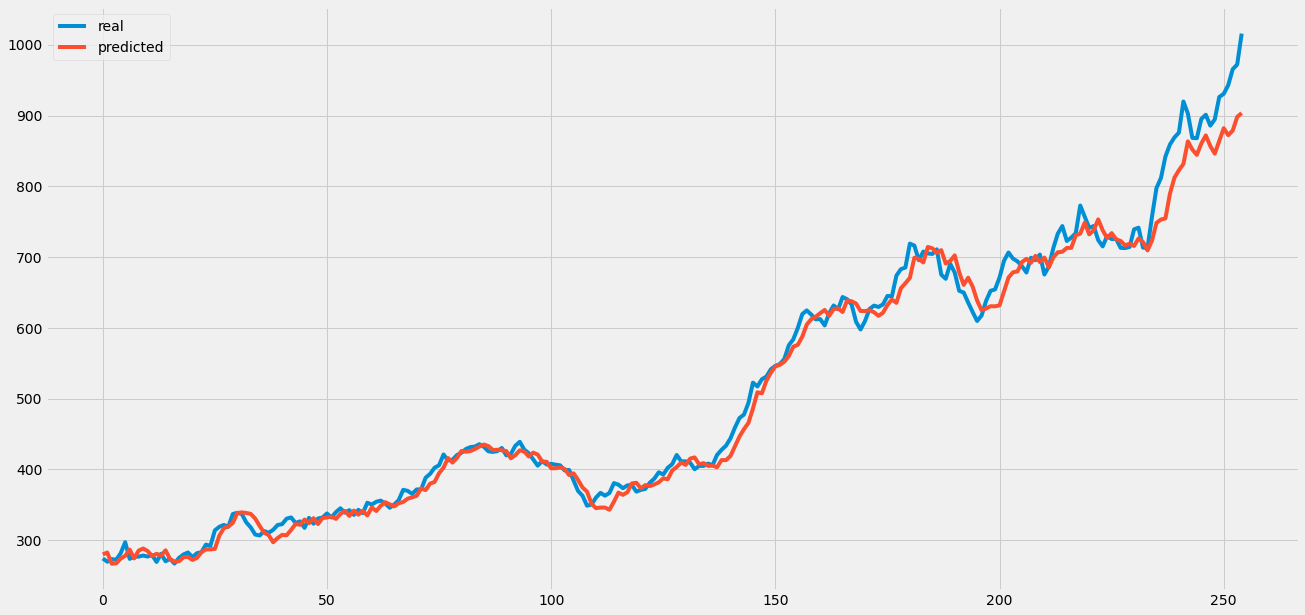

In [ ]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
def create_model2():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model2 = create_model2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 10)          120       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)
print('RMSE: ' + str(my_rmse(y_pred2, scaler.inverse_transform(yvalid))))

Epoch 1/6
313/313 [==============================] - 24s 74ms/step - loss: 0.0280 - val_loss: 0.0027
Epoch 2/6
313/313 [==============================] - 24s 76ms/step - loss: 9.2259e-04 - val_loss: 0.0022
Epoch 3/6
313/313 [==============================] - 23s 75ms/step - loss: 6.4245e-04 - val_loss: 9.9996e-04
Epoch 4/6
313/313 [==============================] - 24s 76ms/step - loss: 5.0541e-04 - val_loss: 7.8217e-04
Epoch 5/6
313/313 [==============================] - 22s 71ms/step - loss: 4.2799e-04 - val_loss: 6.7767e-04
Epoch 6/6
313/313 [==============================] - 25s 79ms/step - loss: 3.8402e-04 - val_loss: 6.1767e-04
RMSE: 23.9578


In [ ]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

print(xdat.shape, ydat.shape)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)


(5246, 50) (5246, 10)
(5000, 50, 1) (246, 50, 1) (5000, 10) (246, 10)


In [ ]:
def create_model3(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model3 = create_model3(out_dim = look_ahead)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, None, 10)          120       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred3 = model3.predict(xvalid)
y_pred3 = scaler.inverse_transform(y_pred3)

Epoch 1/6
313/313 [==============================] - 25s 76ms/step - loss: 0.0307 - val_loss: 0.0064
Epoch 2/6
313/313 [==============================] - 25s 79ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 3/6
313/313 [==============================] - 24s 78ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 4/6
313/313 [==============================] - 23s 73ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 5/6
313/313 [==============================] - 23s 74ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 6/6
313/313 [==============================] - 24s 77ms/step - loss: 0.0012 - val_loss: 0.0027


In [ ]:
print('RMSE: ' + str(my_rmse(y_pred3, scaler.inverse_transform(yvalid))))

RMSE: 49.8271


## Import Libraries

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 541 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
sns.set(style='white')
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb

In [ ]:
# kaggle kernels output umang5916/time-series-analysis-and-forecasting-reliance -p /path/to/dest

## Import dataset

In [ ]:
company_list=["ADANIPORTS.csv","ASIANPAINT.csv","AXISBANK.csv","BAJAJ-AUTO.csv","BAJAJFINSV.csv","BAJFINANCE.csv","BHARTIARTL.csv","BPCL.csv","BRITANNIA.csv","CIPLA.csv","COALINDIA.csv","DRREDDY.csv","EICHERMOT.csv","GAIL.csv","GRASIM.csv","HCLTECH.csv","HDFC.csv","HDFCBANK.csv","HEROMOTOCO.csv","HINDALCO.csv","HINDUNILVR.csv","ICICIBANK.csv","INDUSINDBK.csv","INFRATEL.csv","INFY.csv","IOC.csv","ITC.csv","JSWSTEEL.csv","KOTAKBANK.csv","LT.csv","MARUTI.csv","MM.csv","NESTLEIND.csv","NTPC.csv","ONGC.csv","POWERGRID.csv","RELIANCE.csv","SBIN.csv","SHREECEM.csv","SUNPHARMA.csv","TATAMOTORS.csv","TATASTEEL.csv","TCS.csv","TECHM.csv","TITAN.csv","ULTRACEMCO.csv","UPL.csv","VEDL.csv","WIPRO.csv","ZEEL.csv"]
len(company_list)

50

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf

In [ ]:
df_dict = {}
for x in company_list[:1]:
  df_dict[x] = yf.download(x)

Got error from yahoo api for ticker ADANIPORTS.CSV, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


KeyboardInterrupt: ignored

In [ ]:
start_date = '2021-07-23'
end_date = '2022-07-29'

# Get the data
data = yf.download('ZOMATO.NS', start_date, end_date)

In [ ]:
df=pd.read_csv('RELIANCE.csv')

## Converting Date into DateTime format 

In [ ]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)

In [ ]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


## data summary

In [ ]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5.287000e+03,5.287000e+03,2.437000e+03,4.773000e+03,4773.000000
mean,1007.568148,1009.185531,1023.389928,993.483441,1007.742898,1007.902941,1008.520151,5.574532e+06,6.042490e+14,1.445581e+05,2.276096e+06,0.435035
std,569.149078,570.747642,580.193922,558.816557,569.104743,569.213992,569.385154,4.989907e+06,8.363304e+14,1.299712e+05,1.884015e+06,0.144939
min,203.200000,205.500000,219.500000,197.150000,203.300000,203.200000,212.290000,5.282000e+04,4.295543e+12,2.991000e+03,2.909700e+04,0.076300
25%,571.325000,571.025000,581.275000,563.525000,570.850000,571.450000,570.815000,2.831420e+06,2.196463e+14,7.195800e+04,1.193221e+06,0.322900
50%,936.200000,937.650000,947.700000,925.700000,937.000000,936.600000,937.240000,4.201156e+06,3.650934e+14,1.012470e+05,1.806691e+06,0.449500
75%,1240.825000,1240.025000,1260.125000,1225.675000,1239.875000,1241.700000,1241.635000,6.571430e+06,6.612249e+14,1.664970e+05,2.738858e+06,0.544500
max,3220.850000,3298.000000,3298.000000,3141.300000,3223.000000,3220.850000,3197.750000,6.523089e+07,1.473434e+16,1.428490e+06,3.495888e+07,0.978300


In [ ]:
df.shape

(5287, 14)

## Check for missing values

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_table=missing_values_table(df)
missing_table

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Trades,2850,53.9
Deliverable Volume,514,9.7
%Deliverble,514,9.7


* There are missing vales in Trades , Deliverable Volumne and % deliverable

## Visualizing the locations of the missing data

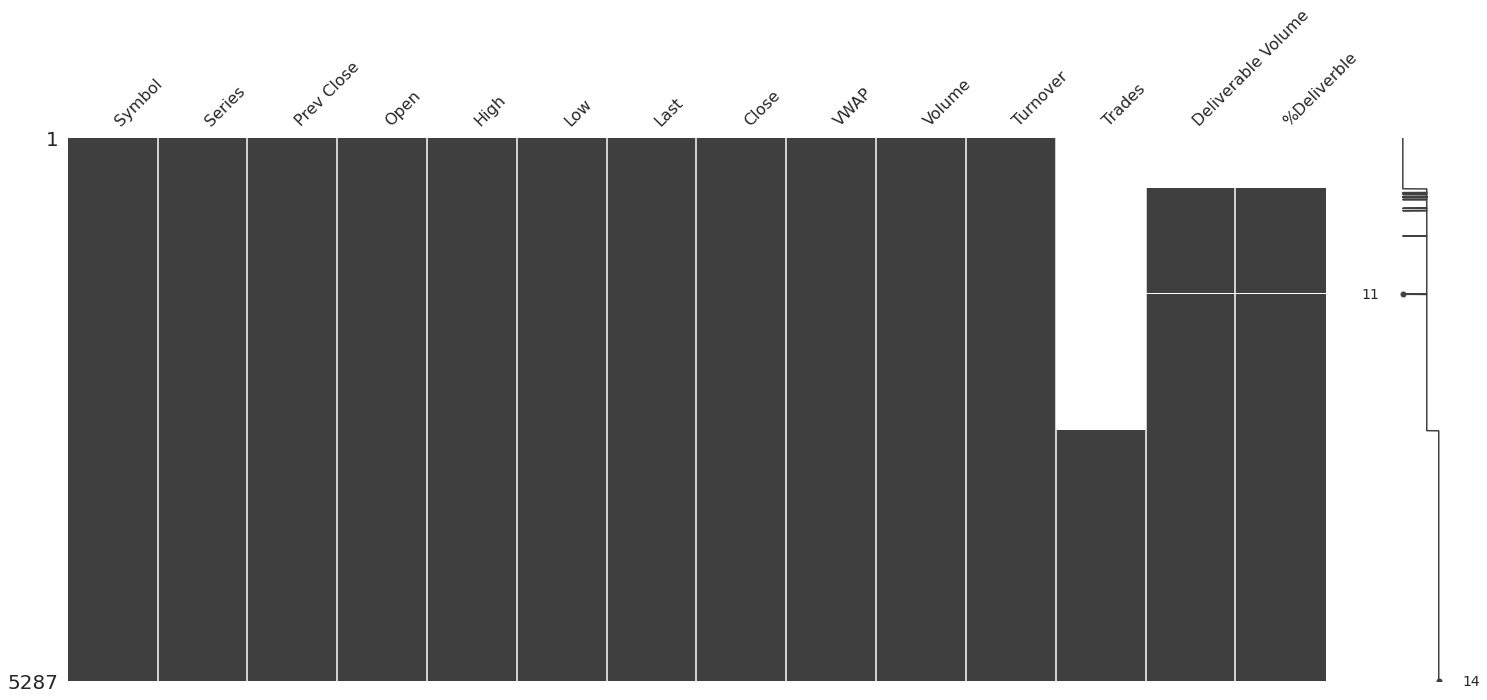

In [ ]:
msno.matrix(df)

* As you can see all the starting values are missing in columns Trades , Deliverable Volume	 and %Deliverble

## Handling missing values 

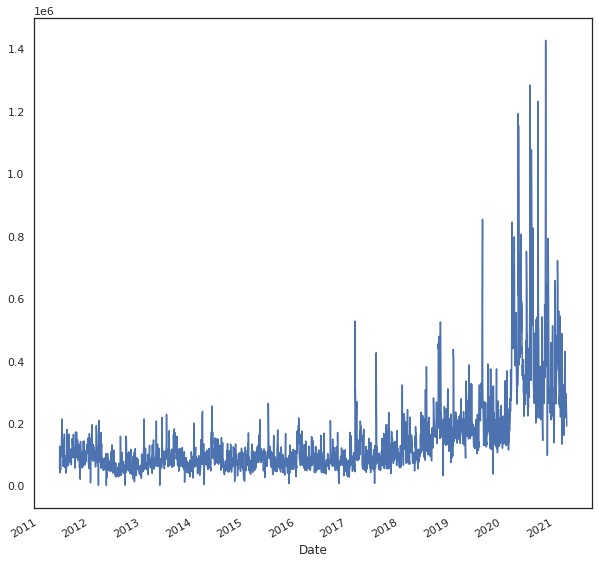

In [ ]:
df.Trades.plot()

In [ ]:
df.Trades[:2850]

Date
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
              ..
2011-05-25   NaN
2011-05-26   NaN
2011-05-27   NaN
2011-05-30   NaN
2011-05-31   NaN
Name: Trades, Length: 2850, dtype: float64

* we don't have data of Trades on and before 31-05-2011 

In [ ]:
# removing missing columns

df.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1,inplace=True)


# Features:
1. Series: Here EQ stands for equity series of stock market.
2. Prev Close: The closing price of the stock for the day before.
3. Open,High, Low, Last, Close: The opening price, highest price, lowest price, last price and closing price of ICICI shares on the current day.
4. **VWAP**: Volume Weighted Average Price,the **target variable** to predict. VWAP is a trading benchmark used by traders that gives the average price the stock has traded at throughout the day, based on both volume and price.
5. Volume: Volume of shares traded on the current day.
6. Turnover: It is a measure of stock liquidity calculated by dividing the total number of shares traded over a period by the average number of shares outstanding for the period. 
7. Trades: total number of trades on the current day.
8. Deliverable Volume:  is the quantity of shares which actually move from one set of people to another set of people.
9. Deliverable(%): Deliverable volume in percentage.

<font size="+3" color='#780404'><b>Exploratory Data Analysis</b></font>

## Plotting VWAP(Volume Weighted Average Price) over time

In [ ]:
fig = go.Figure([go.Scatter(x=df.index, y=df['VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP over time',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

* There is steady increase in prices upto year 2008 
* Stock price fell after jan 2008  and attain pick again in may-june 2009  after that it fell again .

 ## Visualising using KDEs
 Summarizing the data with Density plots to see where the mass of the data is located

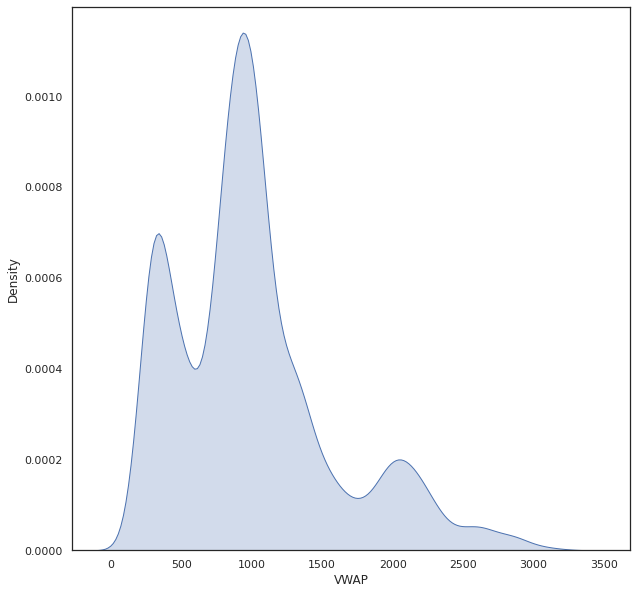

In [ ]:
sns.kdeplot(df['VWAP'],shade=True)

* There are two picks in VWAP prices

## VWAP in 2019

In [ ]:
fig = go.Figure([go.Scatter(x=df.loc['2019', 'VWAP'].index,y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP in 2019',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")

fig.show()

* There was many dips in year 2019 like in May-June , Aug-Sept and in end of the Sept month 

## VWAP in 2020

In [ ]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'VWAP'].index,y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP in 2020',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

* as you can see there is deep in the month of march and april.
* Steady increase after month of april .

## Open,close,High,low prices over time 

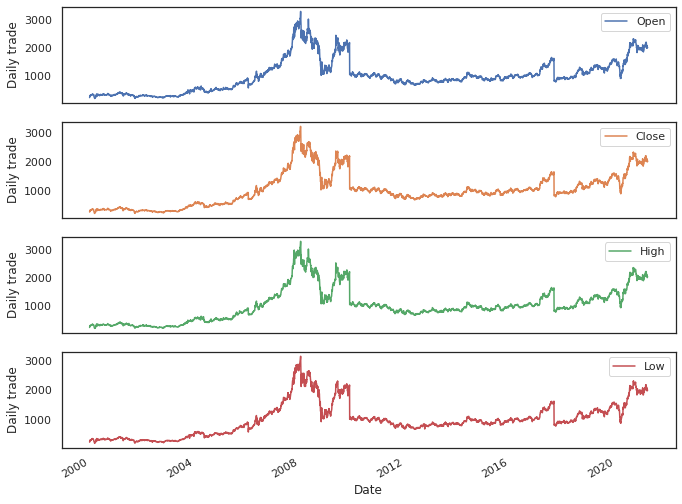

In [ ]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = df[cols_plot].plot(figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

* All are following same pattern 

## Volume over Time 

In [ ]:
fig = go.Figure([go.Scatter(x=df.index, y=df['Volume'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume over time'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

## Volume in 2020

In [ ]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'Volume'].index,y=df.loc['2020', 'Volume'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume in 2020'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

## Q-Q plot of VWAP 

used to determine whether dataset is distributed a certain way 

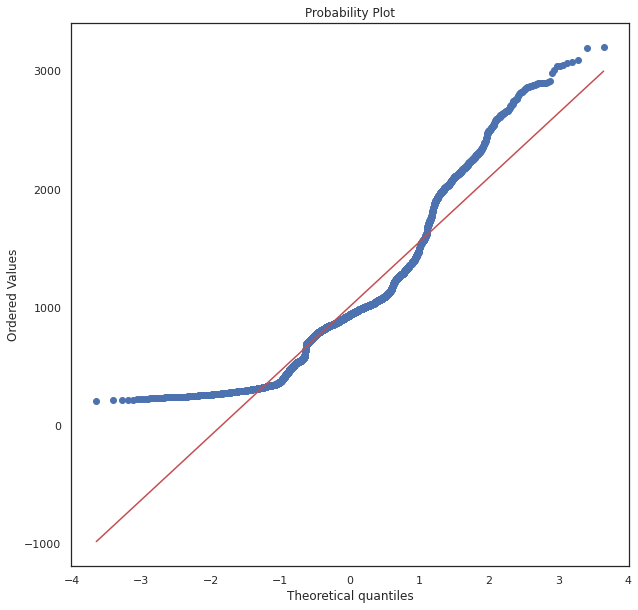

In [ ]:
scipy.stats.probplot(df.VWAP,plot=pylab)
pylab.show()

* data is not normally distributed , however this is what we usually expect from timeseries 

## Stationarity 

In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. The algebraic equivalent is thus a linear function, perhaps, and not a constant one; the value of a linear function changes as 𝒙 grows, but the way it changes remains constant — it has a constant slope; one value that captures that rate of change.

![image.png](attachment:image.png)

Formally, the process {xᵢ ; i∈ℤ} is weakly stationary if:
1. The first moment of xᵢ is constant; i.e. ∀t, E[xᵢ]=𝜇
2. The second moment of xᵢ is finite for all t; i.e. ∀t, E[xᵢ²]<∞ (which also implies of course E[(xᵢ-𝜇)²]<∞; i.e. that variance is finite for all t)
3. The cross moment — i.e. the auto-covariance — depends only on the difference u-v; i.e. ∀u,v,a, cov(xᵤ, xᵥ)=cov(xᵤ₊ₐ, xᵥ₊ₐ)

![image.png](attachment:image.png)

> Note - If you want to know more about stationarity , you can refer this [link](http://https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322#:~:text=In%20the%20most%20intuitive%20sense,not%20itself%20change%20over%20time.)

## Check Stationarity i.e Dicky Fuller Test

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend
It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
def dicky_fuller_test(x):
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [ ]:
dicky_fuller_test(df['VWAP'])

ADF Statistic: -1.827043
p-value: 0.367121
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data is non-stationary


## Seasonal Decompose

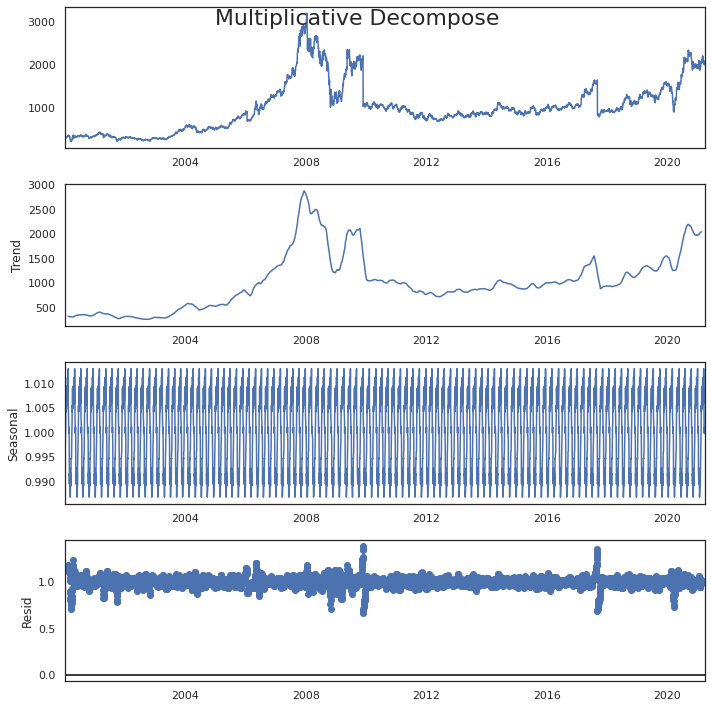

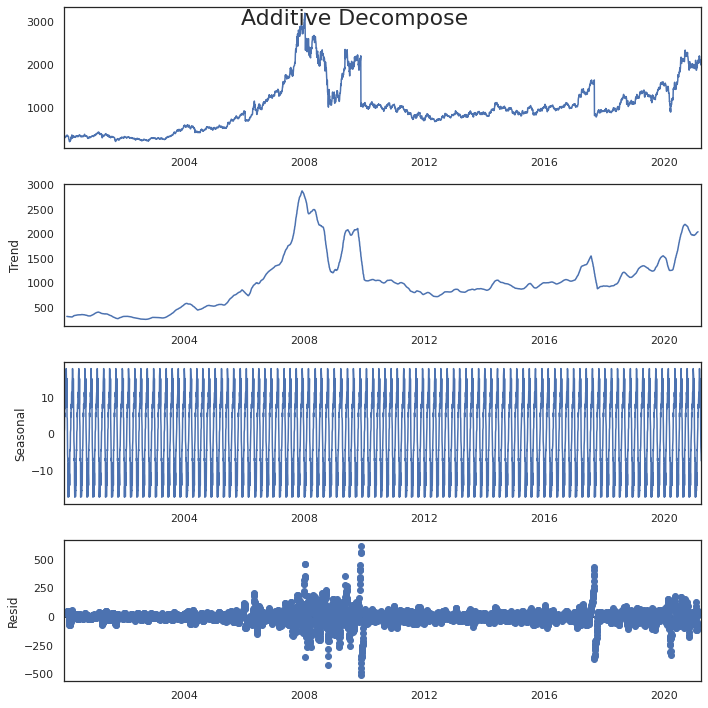

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

plt.rcParams.update({'figure.figsize': (10,10)})
y = df['VWAP'].to_frame()


# Multiplicative Decomposition 
result_mul = seasonal_decompose(y, model='multiplicative',period = 52)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 52)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

* cyclic patter is shown in every 30 days (monthly)

## Convert Stationary into Non Stationary

### Differencing

In [ ]:
df['vwap_diff']=df['VWAP']-df['VWAP'].shift(1)

In [ ]:
fig = go.Figure([go.Scatter(x=df.index,y=df.VWAP)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='VWAP over time ')
fig.show()

In [ ]:
fig = go.Figure([go.Scatter(x=df.index,y=df.vwap_diff)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='difference VWAP over time ')
fig.show()

* We don't actually need to convert the time series data into stationary data. For study purpose,I have explained how to check stationarity and how to convert non-stationary data into stationary data 

## Plotting ACF and PACF 

**Autocorrelation** and **partial autocorrelation** plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

**Statistical correlation** summarizes the strength of the relationship between two variables.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a **serial correlation, or an autocorrelation.**

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a **correlogram or an autocorrelation plot**.

![image.png](attachment:image.png)


A **partial autocorrelation** is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

A **partial autocorrelation** is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

![image.png](attachment:image.png)

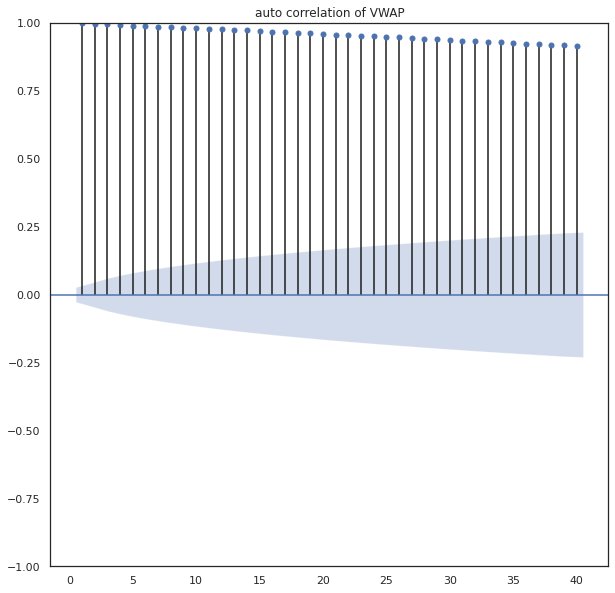

In [ ]:
sm.graphics.tsa.plot_acf(df['VWAP'].iloc[1:], lags=40,title='auto correlation of VWAP',zero=False)
plt.show()

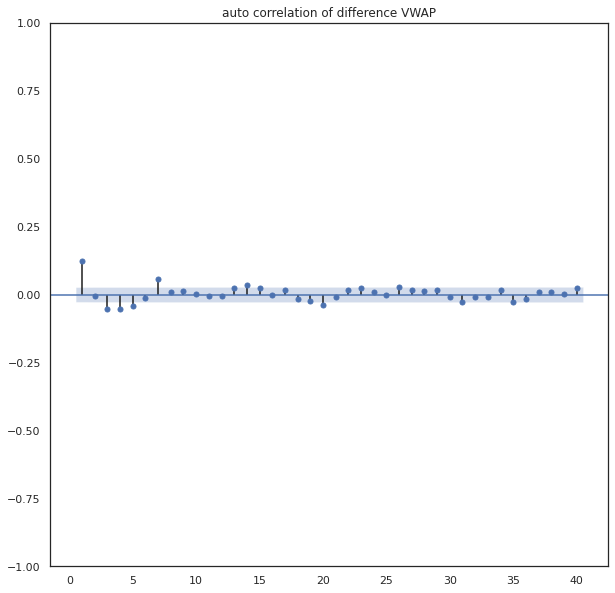

In [ ]:
sm.graphics.tsa.plot_acf(df['vwap_diff'].iloc[7:], lags=40,title='auto correlation of difference VWAP',zero=False)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



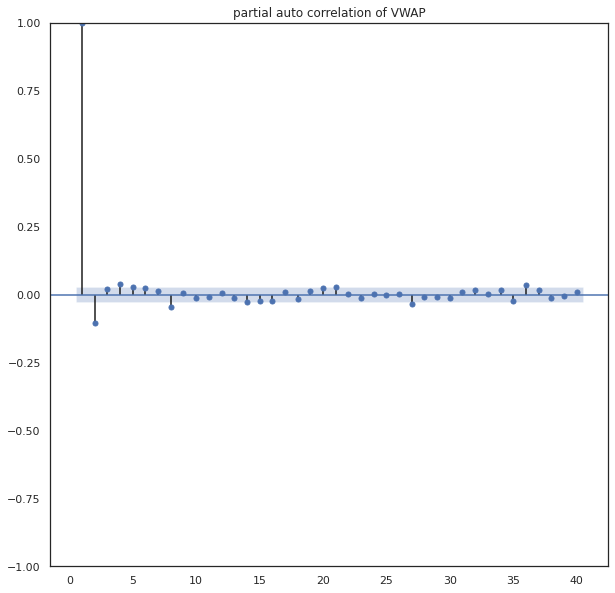

In [ ]:
sm.graphics.tsa.plot_pacf(df['VWAP'].iloc[1:], lags=40,title='partial auto correlation of VWAP',zero=False)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



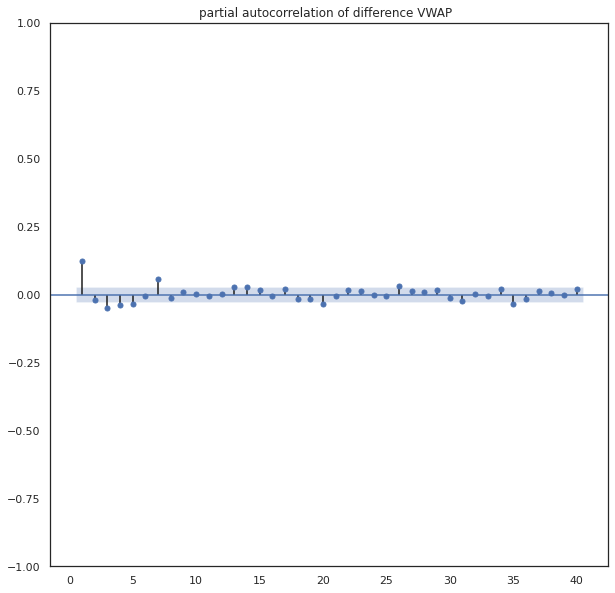

In [ ]:
sm.graphics.tsa.plot_pacf(df['vwap_diff'].iloc[1:], lags=40,title='partial autocorrelation of difference VWAP  ',zero=False)
plt.show()

<font size="+3" color='#780404'><b> Feature Engineering </b></font>

Adding lag values of High, Low, Volume,Turnover, will use three sets of lagged values, one previous day, one looking back 7 days and another looking back 30 days as a proxy for last week and last month metrics.

In [ ]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,vwap_diff
Date,,,,,,,,,,,,
2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN
2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,14.15
2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,11.27
2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,20.66
2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,13.46


In [ ]:
df=df.reset_index()

In [ ]:
lag_features = ["High", "Low", "Volume", "Turnover","Close"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [ ]:

df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Close_mean_lag3,Close_mean_lag7,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,...,1007.381226,1006.716797,1002.789062,14.768536,22.749413,47.497242,1,1,3,0
2000-01-04,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,...,251.699997,251.699997,251.699997,14.768536,22.749413,47.497242,1,1,4,1
2000-01-05,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,...,261.774994,261.774994,261.774994,14.248201,14.248201,14.248201,1,1,5,2
2000-01-06,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,...,268.683319,268.683319,268.683319,15.642277,15.642277,15.642277,1,1,6,3
2000-01-07,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,...,282.899994,275.100006,275.100006,11.255332,18.105661,18.105661,1,1,7,4


In [ ]:

df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3","High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7","High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Close_mean_lag3", "Close_mean_lag7","Close_mean_lag30","Close_std_lag3","Close_std_lag7","Close_std_lag30",
                      "Turnover_std_lag30","month","week","day","day_of_week"]


In [ ]:
df_valid['Date'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                     558
unique                    558
top       2019-01-01 00:00:00
freq                        1
first     2019-01-01 00:00:00
last      2021-03-31 00:00:00
Name: Date, dtype: object

# AutoRegressor:
A model that uses the dependent relationship between an observation and some number of lagged observations.
> "We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling."-https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/<br>

AR(1) model<br>
Rt = μ + ϕRt-1 + εt<br>

As RHS has only one lagged value(Rt-1)this is called AR model of order 1 where μ is mean and ε is noise at time t
If ϕ = 1, it is random walk. Else if ϕ = 0, it is white noise. Else if -1 < ϕ < 1, it is stationary. If ϕ is -ve, there is men reversion. If ϕ is +ve, there is momentum.<br>

AR(2) model<br>
Rt = μ + ϕ1Rt-1 + ϕ2Rt-2 + εt<br>

AR(3) model<br>
Rt = μ + ϕ1Rt-1 + ϕ2Rt-2 + ϕ3Rt-3 + εt<br>

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(df_train.VWAP,lags=3, exog=df_train[exogenous_features])
res = model.fit()
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                 4729
Model:                   AutoReg-X(3)   Log Likelihood              -22660.353
Method:               Conditional MLE   S.D. of innovations             29.250
Date:                Sun, 06 Nov 2022   AIC                          45398.706
Time:                        13:40:17   BIC                          45650.678
Sample:                             3   HQIC                         45487.270
                                 4729                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0052      0.007     -0.754      0.451      -0.019       0.008
VWAP.L1                 0.4672      0.059      7.906      0.000       0.351       0.583
VWAP.L2         

In [ ]:
res = model.fit(cov_type="HC0")
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                 4729
Model:                   AutoReg-X(3)   Log Likelihood              -22660.353
Method:               Conditional MLE   S.D. of innovations             29.250
Date:                Sun, 06 Nov 2022   AIC                          45398.706
Time:                        13:40:17   BIC                          45650.678
Sample:                             3   HQIC                         45487.270
                                 4729                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0052      0.006     -0.931      0.352      -0.016       0.006
VWAP.L1                 0.4672      0.134      3.479      0.001       0.204       0.730
VWAP.L2         

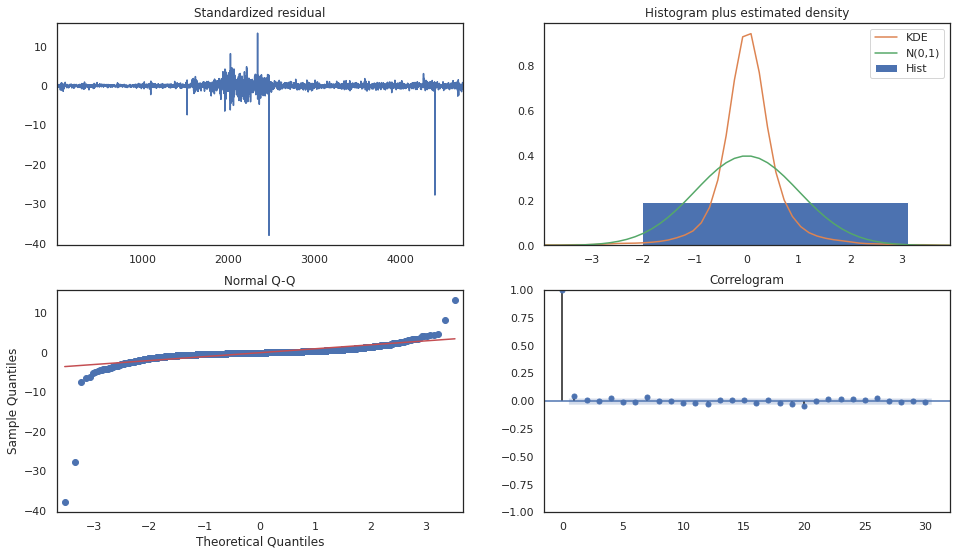

In [ ]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)

<font size="+3" color='#780404'><b> AUTO-ARIMA Model </b></font>

In [ ]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=45769.461, Time=7.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45860.449, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45799.168, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=45797.991, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45858.618, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=45792.034, Time=7.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=45784.512, Time=9.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=45769.033, Time=15.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=45777.210, Time=4.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=45775.336, Time=10.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=12.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=45768.822, Time=4.99 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=45781.075, Time=3.19 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=45769.990, Time=10.17 sec
 ARIMA(1,1,4)(0,0,0)[

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4729
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -22877.483
Date:                Sun, 06 Nov 2022   AIC                          45766.967
Time:                        13:42:38   BIC                          45805.734
Sample:                             0   HQIC                         45780.593
                               - 4729                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1585      0.056     20.777      0.000       1.049       1.268
ar.L2         -0.7675      0.051    -15.118      0.000      -0.867      -0.668
ma.L1         -1.0462      0.056    -18.550      0.000      -1.157      -0.936
ma.L2          0.6411      0.047     13.682      0.000       0.549       0.733
ma.L3          0.0375      0.013      2.876      0.004       0.012       0.063
sigma2       933.9666      1.503    621.538      0.000     931.021     936.912
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          53010351.44
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.91   Skew:                           -14.74
Prob(H) (two-sided):                  0.00   Kurtosis:                       520.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

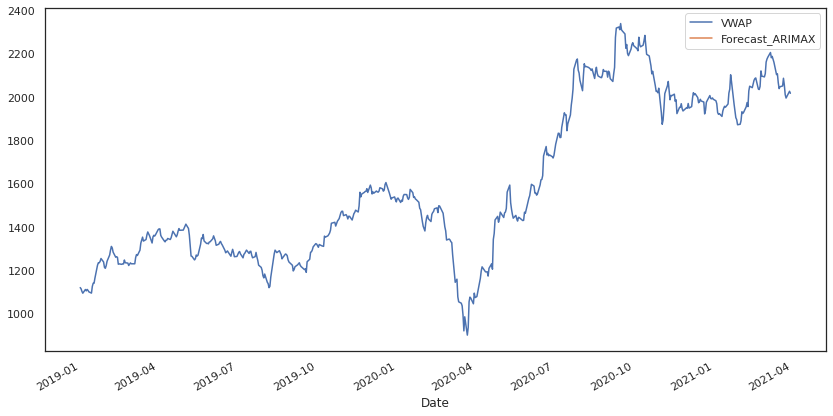

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

ValueError: ignored

The Auto ARIMAX model seems to do a fairly good job in predicting the stock price given data till the previous day. Can other models beat this benchmark?

## Facebook Prophet
Prophet is an open-source time series model developed by Facebook. It was released in early 2017. An exerpt from the homepage:

> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Read more about Prophet: https://facebook.github.io/prophet/

I also shared a starter code [Prophet's Prophecy](https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy) for using Prophet in the ASHRAE competition on Kaggle.

Note that the default parameters are used for Prophet. They can be tuned to improve the results.

In [ ]:
from fbprophet import Prophet

model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

In [ ]:
model_fbp.plot_components(forecast)

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))

## LightGBM
Time series problems are popularly converted into a tabular i.i.d. structure and fed into boosting models like [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [XGBoost](https://xgboost.readthedocs.io/en/latest/).

There is loss of information in terms of knowing the order of data points in the time series but it can be circumvented by the datetime features to capture this information to some extent.

Note that the default parameters are used for LightGBM. They can be tuned to improve the results.

In [ ]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.VWAP.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_LightGBM)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))
print("MAE of LightGBM:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_LightGBM))

ARIMA, Prophet and LightGBM models give a fair rmse and mae score. Let's see if deep learning models can do a better job in fitting to our dataset.

# Deep Learning Models 
Let's explore some deep learning models on the dataset.
We'll try LTSM and RNN. RNN, a model designed for allowing information to persist in short term memory to predict subsequent values, should be best suited to our dataset, since we can see that autocorrelations don't show signs of seasonality, it tends to be manipulated by recent previous prices. We'll also apply LTSM, the special RNN model, which might reveal some interesting long term dependencies or relations in the dataset. Let's explore!

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [ ]:
fig = plt.figure(figsize = (17,25))
ax = fig.gca()
hist=df.hist(ax = ax)

In [ ]:
dataset = df[exogenous_features].values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
X_train = train[:,1:]
y_train = train[:,0]
X_test = test[:,1:]
y_test = test[:,0]

In [ ]:
batch_size = 1
timesteps = 1
units = 100
nb_epoch = 70

In [ ]:
X_train = X_train.reshape(X_train.shape[0],timesteps,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],timesteps,X_test.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(units,batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)

In [ ]:
model.summary()

In [ ]:
yhat = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat)
print('rmse:{} MAE:{}'.format(rmse,mae))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="actual")
plt.plot(yhat, label="prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Vwap', size=15)
plt.xlabel('points', size=15)
plt.legend(fontsize=15)
plt.show();

LSTM gives an excellent score on our dataset. Let's checkout a simple RNN model!

In [ ]:
model = Sequential()
model.add(SimpleRNN(units,batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)
model.summary()

In [ ]:
yhat2 = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat2)
print('rmse:{} MAE:{}'.format(rmse,mae))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('RNN model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="actual")
plt.plot(yhat2, label="prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Vwap', size=15)
plt.xlabel('points', size=15)
plt.legend(fontsize=15)
plt.show();

RNN performs rather poorly, in comparison to LTSM model, Though the RMSE score turned out to be the same approximately, MAE has increased by 3-4%, as we can see the results from the graphs above. We can say that, when we move from RNN to LSTM, we are introducing more & more controlling knobs, which control the flow and mixing of Inputs as per trained Weights. And thus, bringing in more flexibility in controlling the outputs. Thus, we obtain better results in LTSM.

<font size="+3" color='#780404'><b> Analyzing residuals </b></font>

In [ ]:
residuals=df_valid.VWAP-df_valid.Forecast_ARIMAX

In [ ]:
dicky_fuller_test((residuals))

In [ ]:
residuals.plot()

<font size="+3" color='#780404'><b> Evaluating Model </b></font>

## Conclusions and Tips
* Auto ARIMAX is a great baseline model but newer algorithms like Facebook's Prophet are extremely powerful and are getting cleverer by the day. Don't feel afraid to try out new techniques.
* Setting up an appropriate validation framework is extremely important. It enables you to try and experiment various models and objectively compare them.
* Lag-based features are very useful in providing trends information about the time series data. Rolling statistics are a common way of generating these.
* Exogenous regressors help in providing external information about the time series. They tend to be very important in most models.
* Boosting models like LightGBM are constrained to predict within the range of values of the target variable in the training data and don't extrapolate when there is strong trend.
* Converting a time series to stationary and then modelling is a common approach for building solutions and can significantly improve results.

<font size="+1" color='#9b24a3'><b>I hope you enjoyed this kernel , Please don't forget to appreciate me with an Upvote.</b></font>

<img src="https://i.pinimg.com/originals/e2/d7/c7/e2d7c71b09ae9041c310cb6b2e2918da.gif">

## Import Libraries

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 541 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
sns.set(style='white')
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb

In [ ]:
# kaggle kernels output umang5916/time-series-analysis-and-forecasting-reliance -p /path/to/dest

## Import dataset

In [ ]:
company_list=["ADANIPORTS.csv","ASIANPAINT.csv","AXISBANK.csv","BAJAJ-AUTO.csv","BAJAJFINSV.csv","BAJFINANCE.csv","BHARTIARTL.csv","BPCL.csv","BRITANNIA.csv","CIPLA.csv","COALINDIA.csv","DRREDDY.csv","EICHERMOT.csv","GAIL.csv","GRASIM.csv","HCLTECH.csv","HDFC.csv","HDFCBANK.csv","HEROMOTOCO.csv","HINDALCO.csv","HINDUNILVR.csv","ICICIBANK.csv","INDUSINDBK.csv","INFRATEL.csv","INFY.csv","IOC.csv","ITC.csv","JSWSTEEL.csv","KOTAKBANK.csv","LT.csv","MARUTI.csv","MM.csv","NESTLEIND.csv","NTPC.csv","ONGC.csv","POWERGRID.csv","RELIANCE.csv","SBIN.csv","SHREECEM.csv","SUNPHARMA.csv","TATAMOTORS.csv","TATASTEEL.csv","TCS.csv","TECHM.csv","TITAN.csv","ULTRACEMCO.csv","UPL.csv","VEDL.csv","WIPRO.csv","ZEEL.csv"]
len(company_list)

50

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf

In [ ]:
df_dict = {}
for x in company_list[:1]:
  df_dict[x] = yf.download(x)

Got error from yahoo api for ticker ADANIPORTS.CSV, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


KeyboardInterrupt: ignored

In [ ]:
start_date = '2021-07-23'
end_date = '2022-07-29'

# Get the data
data = yf.download('ZOMATO.NS', start_date, end_date)

In [ ]:
df=pd.read_csv('RELIANCE.csv')

## Converting Date into DateTime format 

In [ ]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)

In [ ]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


## data summary

In [ ]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5287.000000,5.287000e+03,5.287000e+03,2.437000e+03,4.773000e+03,4773.000000
mean,1007.568148,1009.185531,1023.389928,993.483441,1007.742898,1007.902941,1008.520151,5.574532e+06,6.042490e+14,1.445581e+05,2.276096e+06,0.435035
std,569.149078,570.747642,580.193922,558.816557,569.104743,569.213992,569.385154,4.989907e+06,8.363304e+14,1.299712e+05,1.884015e+06,0.144939
min,203.200000,205.500000,219.500000,197.150000,203.300000,203.200000,212.290000,5.282000e+04,4.295543e+12,2.991000e+03,2.909700e+04,0.076300
25%,571.325000,571.025000,581.275000,563.525000,570.850000,571.450000,570.815000,2.831420e+06,2.196463e+14,7.195800e+04,1.193221e+06,0.322900
50%,936.200000,937.650000,947.700000,925.700000,937.000000,936.600000,937.240000,4.201156e+06,3.650934e+14,1.012470e+05,1.806691e+06,0.449500
75%,1240.825000,1240.025000,1260.125000,1225.675000,1239.875000,1241.700000,1241.635000,6.571430e+06,6.612249e+14,1.664970e+05,2.738858e+06,0.544500
max,3220.850000,3298.000000,3298.000000,3141.300000,3223.000000,3220.850000,3197.750000,6.523089e+07,1.473434e+16,1.428490e+06,3.495888e+07,0.978300


In [ ]:
df.shape

(5287, 14)

## Check for missing values

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_table=missing_values_table(df)
missing_table

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Trades,2850,53.9
Deliverable Volume,514,9.7
%Deliverble,514,9.7


* There are missing vales in Trades , Deliverable Volumne and % deliverable

## Visualizing the locations of the missing data

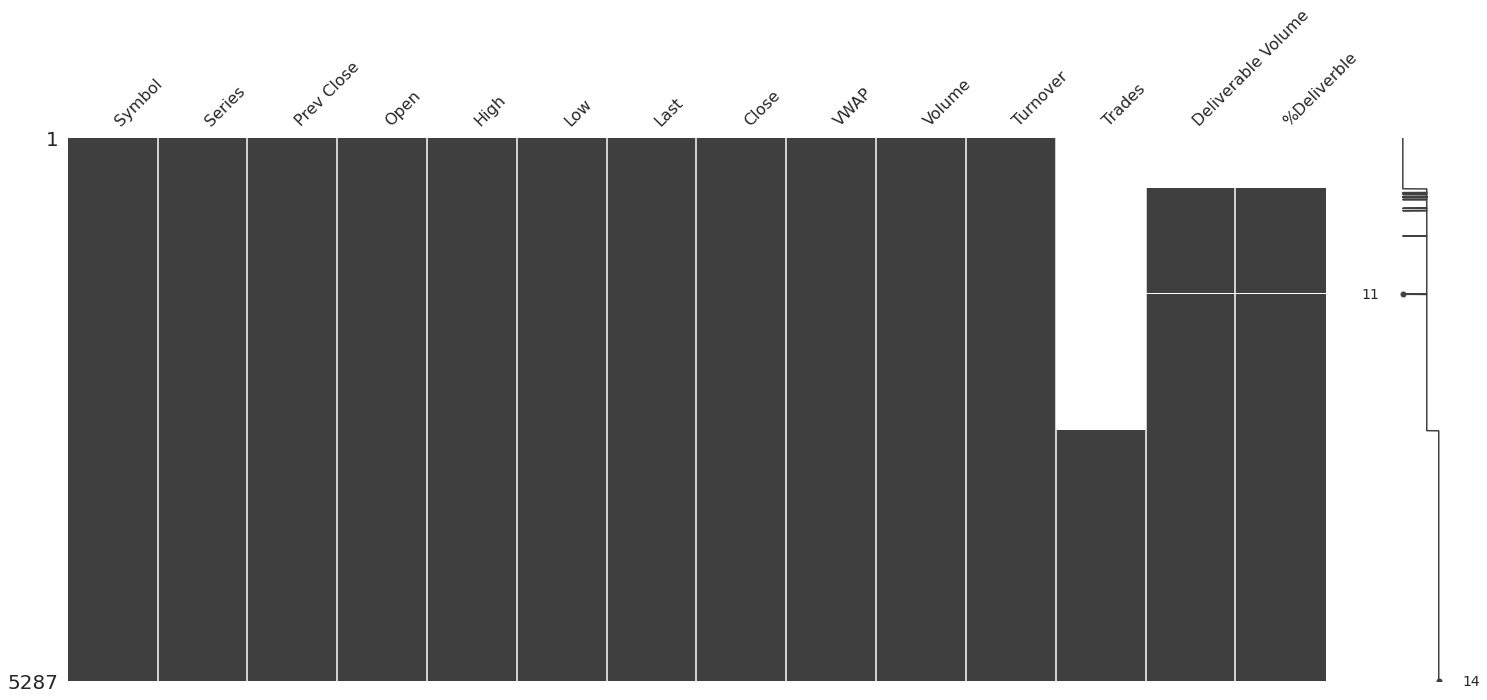

In [ ]:
msno.matrix(df)

* As you can see all the starting values are missing in columns Trades , Deliverable Volume	 and %Deliverble

## Handling missing values 

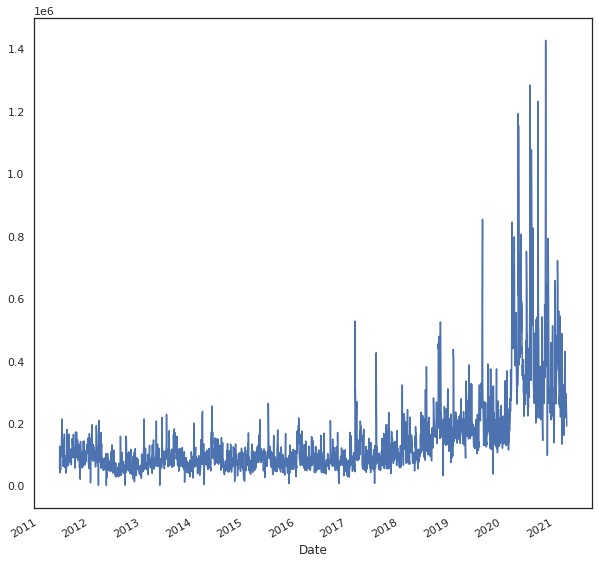

In [ ]:
df.Trades.plot()

In [ ]:
df.Trades[:2850]

Date
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
              ..
2011-05-25   NaN
2011-05-26   NaN
2011-05-27   NaN
2011-05-30   NaN
2011-05-31   NaN
Name: Trades, Length: 2850, dtype: float64

* we don't have data of Trades on and before 31-05-2011 

In [ ]:
# removing missing columns

df.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1,inplace=True)


# Features:
1. Series: Here EQ stands for equity series of stock market.
2. Prev Close: The closing price of the stock for the day before.
3. Open,High, Low, Last, Close: The opening price, highest price, lowest price, last price and closing price of ICICI shares on the current day.
4. **VWAP**: Volume Weighted Average Price,the **target variable** to predict. VWAP is a trading benchmark used by traders that gives the average price the stock has traded at throughout the day, based on both volume and price.
5. Volume: Volume of shares traded on the current day.
6. Turnover: It is a measure of stock liquidity calculated by dividing the total number of shares traded over a period by the average number of shares outstanding for the period. 
7. Trades: total number of trades on the current day.
8. Deliverable Volume:  is the quantity of shares which actually move from one set of people to another set of people.
9. Deliverable(%): Deliverable volume in percentage.

<font size="+3" color='#780404'><b>Exploratory Data Analysis</b></font>

## Plotting VWAP(Volume Weighted Average Price) over time

In [ ]:
fig = go.Figure([go.Scatter(x=df.index, y=df['VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP over time',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

* There is steady increase in prices upto year 2008 
* Stock price fell after jan 2008  and attain pick again in may-june 2009  after that it fell again .

 ## Visualising using KDEs
 Summarizing the data with Density plots to see where the mass of the data is located

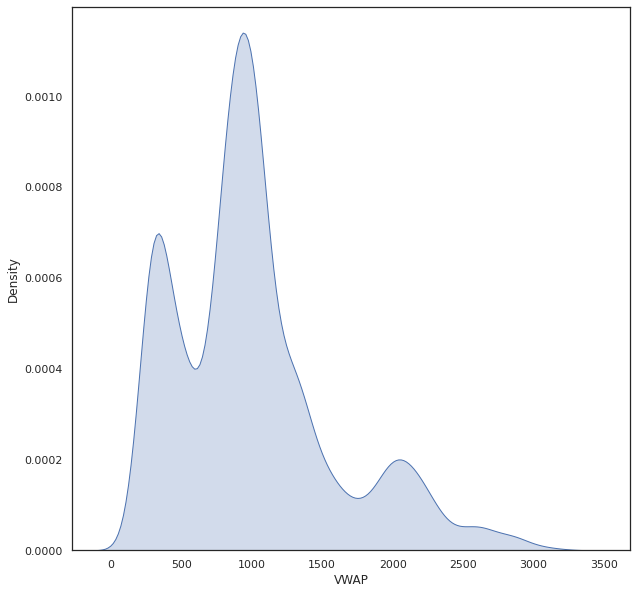

In [ ]:
sns.kdeplot(df['VWAP'],shade=True)

* There are two picks in VWAP prices

## VWAP in 2019

In [ ]:
fig = go.Figure([go.Scatter(x=df.loc['2019', 'VWAP'].index,y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP in 2019',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")

fig.show()

* There was many dips in year 2019 like in May-June , Aug-Sept and in end of the Sept month 

## VWAP in 2020

In [ ]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'VWAP'].index,y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP in 2020',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

* as you can see there is deep in the month of march and april.
* Steady increase after month of april .

## Open,close,High,low prices over time 

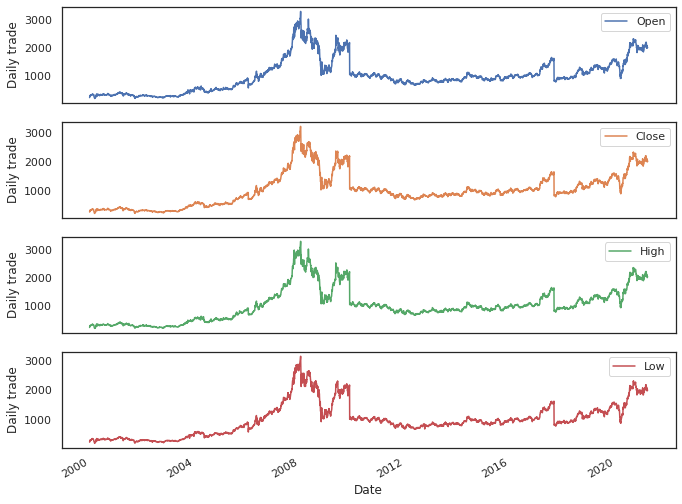

In [ ]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = df[cols_plot].plot(figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

* All are following same pattern 

## Volume over Time 

In [ ]:
fig = go.Figure([go.Scatter(x=df.index, y=df['Volume'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume over time'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

## Volume in 2020

In [ ]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'Volume'].index,y=df.loc['2020', 'Volume'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume in 2020'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

## Q-Q plot of VWAP 

used to determine whether dataset is distributed a certain way 

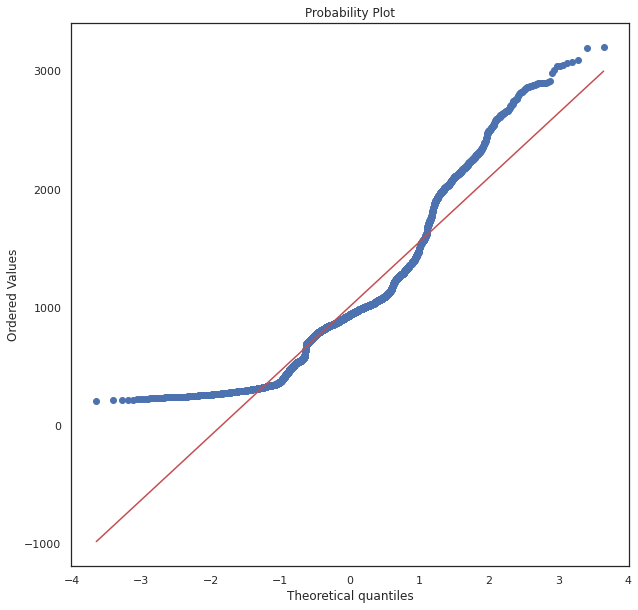

In [ ]:
scipy.stats.probplot(df.VWAP,plot=pylab)
pylab.show()

* data is not normally distributed , however this is what we usually expect from timeseries 

## Stationarity 

In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. The algebraic equivalent is thus a linear function, perhaps, and not a constant one; the value of a linear function changes as 𝒙 grows, but the way it changes remains constant — it has a constant slope; one value that captures that rate of change.

![image.png](attachment:image.png)

Formally, the process {xᵢ ; i∈ℤ} is weakly stationary if:
1. The first moment of xᵢ is constant; i.e. ∀t, E[xᵢ]=𝜇
2. The second moment of xᵢ is finite for all t; i.e. ∀t, E[xᵢ²]<∞ (which also implies of course E[(xᵢ-𝜇)²]<∞; i.e. that variance is finite for all t)
3. The cross moment — i.e. the auto-covariance — depends only on the difference u-v; i.e. ∀u,v,a, cov(xᵤ, xᵥ)=cov(xᵤ₊ₐ, xᵥ₊ₐ)

![image.png](attachment:image.png)

> Note - If you want to know more about stationarity , you can refer this [link](http://https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322#:~:text=In%20the%20most%20intuitive%20sense,not%20itself%20change%20over%20time.)

## Check Stationarity i.e Dicky Fuller Test

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend
It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
def dicky_fuller_test(x):
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [ ]:
dicky_fuller_test(df['VWAP'])

ADF Statistic: -1.827043
p-value: 0.367121
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data is non-stationary


## Seasonal Decompose

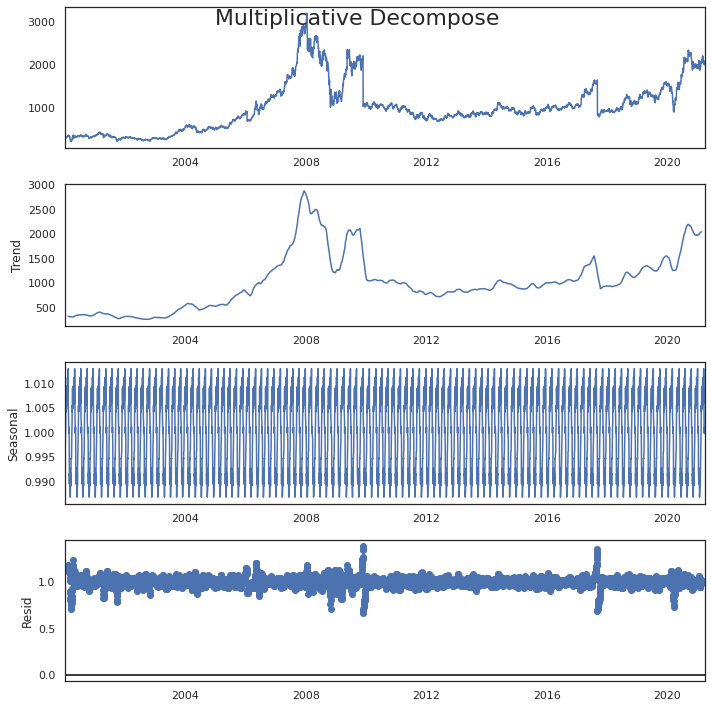

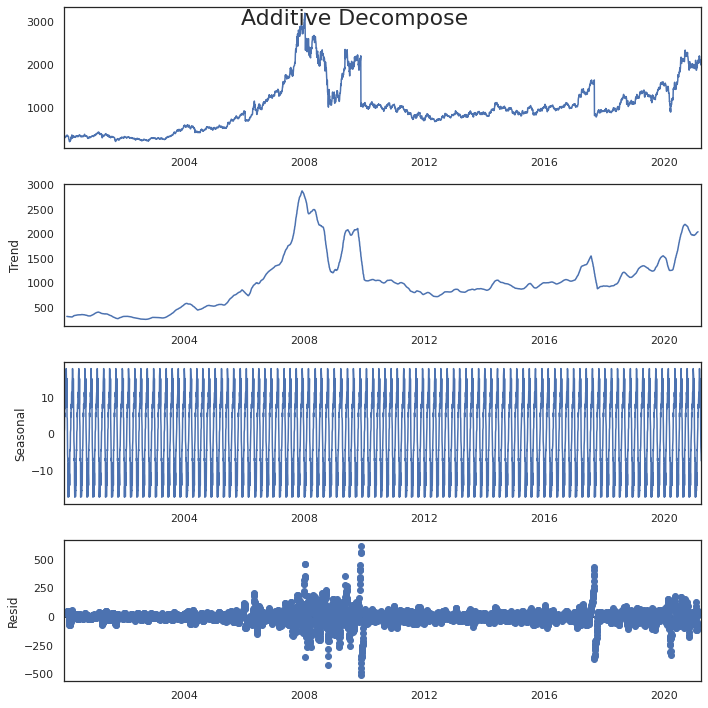

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

plt.rcParams.update({'figure.figsize': (10,10)})
y = df['VWAP'].to_frame()


# Multiplicative Decomposition 
result_mul = seasonal_decompose(y, model='multiplicative',period = 52)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 52)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

* cyclic patter is shown in every 30 days (monthly)

## Convert Stationary into Non Stationary

### Differencing

In [ ]:
df['vwap_diff']=df['VWAP']-df['VWAP'].shift(1)

In [ ]:
fig = go.Figure([go.Scatter(x=df.index,y=df.VWAP)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='VWAP over time ')
fig.show()

In [ ]:
fig = go.Figure([go.Scatter(x=df.index,y=df.vwap_diff)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='difference VWAP over time ')
fig.show()

* We don't actually need to convert the time series data into stationary data. For study purpose,I have explained how to check stationarity and how to convert non-stationary data into stationary data 

## Plotting ACF and PACF 

**Autocorrelation** and **partial autocorrelation** plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

**Statistical correlation** summarizes the strength of the relationship between two variables.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a **serial correlation, or an autocorrelation.**

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a **correlogram or an autocorrelation plot**.

![image.png](attachment:image.png)


A **partial autocorrelation** is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

A **partial autocorrelation** is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

![image.png](attachment:image.png)

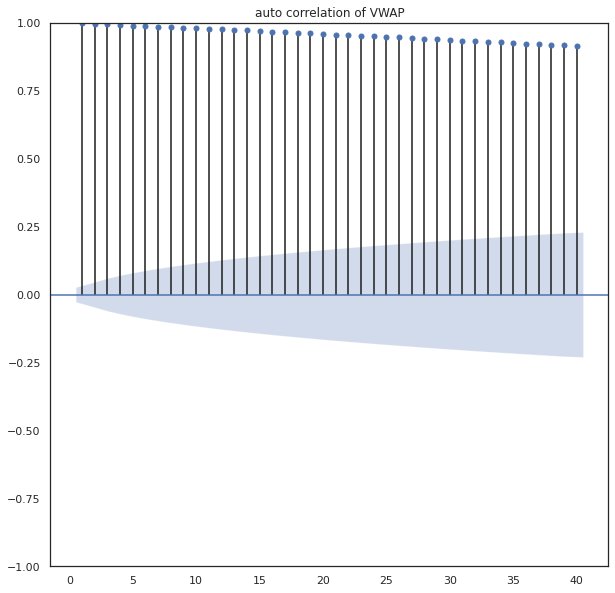

In [ ]:
sm.graphics.tsa.plot_acf(df['VWAP'].iloc[1:], lags=40,title='auto correlation of VWAP',zero=False)
plt.show()

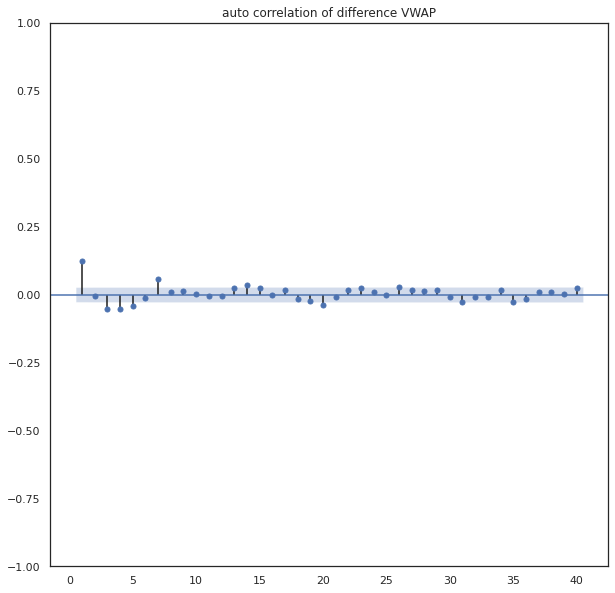

In [ ]:
sm.graphics.tsa.plot_acf(df['vwap_diff'].iloc[7:], lags=40,title='auto correlation of difference VWAP',zero=False)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



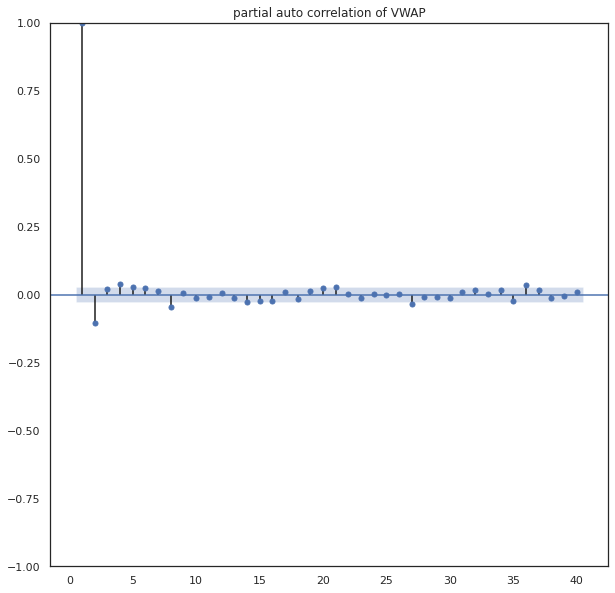

In [ ]:
sm.graphics.tsa.plot_pacf(df['VWAP'].iloc[1:], lags=40,title='partial auto correlation of VWAP',zero=False)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



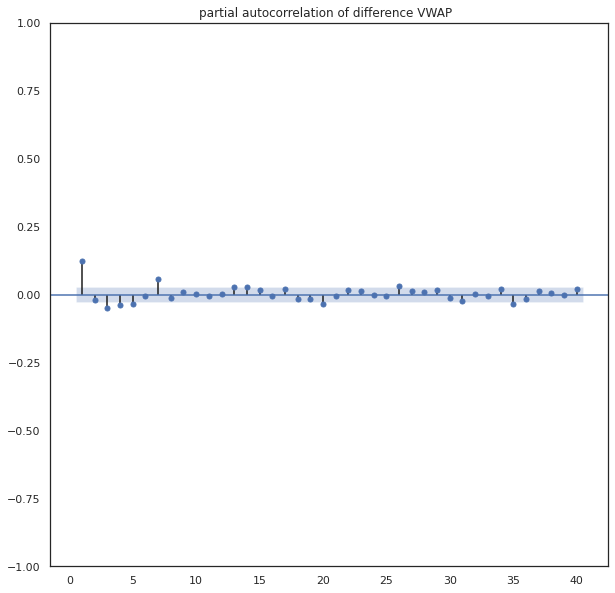

In [ ]:
sm.graphics.tsa.plot_pacf(df['vwap_diff'].iloc[1:], lags=40,title='partial autocorrelation of difference VWAP  ',zero=False)
plt.show()

<font size="+3" color='#780404'><b> Feature Engineering </b></font>

Adding lag values of High, Low, Volume,Turnover, will use three sets of lagged values, one previous day, one looking back 7 days and another looking back 30 days as a proxy for last week and last month metrics.

In [ ]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,vwap_diff
Date,,,,,,,,,,,,
2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN
2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,14.15
2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,11.27
2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,20.66
2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,13.46


In [ ]:
df=df.reset_index()

In [ ]:
lag_features = ["High", "Low", "Volume", "Turnover","Close"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [ ]:

df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Close_mean_lag3,Close_mean_lag7,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,...,1007.381226,1006.716797,1002.789062,14.768536,22.749413,47.497242,1,1,3,0
2000-01-04,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,...,251.699997,251.699997,251.699997,14.768536,22.749413,47.497242,1,1,4,1
2000-01-05,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,...,261.774994,261.774994,261.774994,14.248201,14.248201,14.248201,1,1,5,2
2000-01-06,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,...,268.683319,268.683319,268.683319,15.642277,15.642277,15.642277,1,1,6,3
2000-01-07,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,...,282.899994,275.100006,275.100006,11.255332,18.105661,18.105661,1,1,7,4


In [ ]:

df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3","High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7","High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Close_mean_lag3", "Close_mean_lag7","Close_mean_lag30","Close_std_lag3","Close_std_lag7","Close_std_lag30",
                      "Turnover_std_lag30","month","week","day","day_of_week"]


In [ ]:
df_valid['Date'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                     558
unique                    558
top       2019-01-01 00:00:00
freq                        1
first     2019-01-01 00:00:00
last      2021-03-31 00:00:00
Name: Date, dtype: object

# AutoRegressor:
A model that uses the dependent relationship between an observation and some number of lagged observations.
> "We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling."-https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/<br>

AR(1) model<br>
Rt = μ + ϕRt-1 + εt<br>

As RHS has only one lagged value(Rt-1)this is called AR model of order 1 where μ is mean and ε is noise at time t
If ϕ = 1, it is random walk. Else if ϕ = 0, it is white noise. Else if -1 < ϕ < 1, it is stationary. If ϕ is -ve, there is men reversion. If ϕ is +ve, there is momentum.<br>

AR(2) model<br>
Rt = μ + ϕ1Rt-1 + ϕ2Rt-2 + εt<br>

AR(3) model<br>
Rt = μ + ϕ1Rt-1 + ϕ2Rt-2 + ϕ3Rt-3 + εt<br>

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(df_train.VWAP,lags=3, exog=df_train[exogenous_features])
res = model.fit()
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                 4729
Model:                   AutoReg-X(3)   Log Likelihood              -22660.353
Method:               Conditional MLE   S.D. of innovations             29.250
Date:                Sun, 06 Nov 2022   AIC                          45398.706
Time:                        13:40:17   BIC                          45650.678
Sample:                             3   HQIC                         45487.270
                                 4729                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0052      0.007     -0.754      0.451      -0.019       0.008
VWAP.L1                 0.4672      0.059      7.906      0.000       0.351       0.583
VWAP.L2         

In [ ]:
res = model.fit(cov_type="HC0")
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                 4729
Model:                   AutoReg-X(3)   Log Likelihood              -22660.353
Method:               Conditional MLE   S.D. of innovations             29.250
Date:                Sun, 06 Nov 2022   AIC                          45398.706
Time:                        13:40:17   BIC                          45650.678
Sample:                             3   HQIC                         45487.270
                                 4729                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0052      0.006     -0.931      0.352      -0.016       0.006
VWAP.L1                 0.4672      0.134      3.479      0.001       0.204       0.730
VWAP.L2         

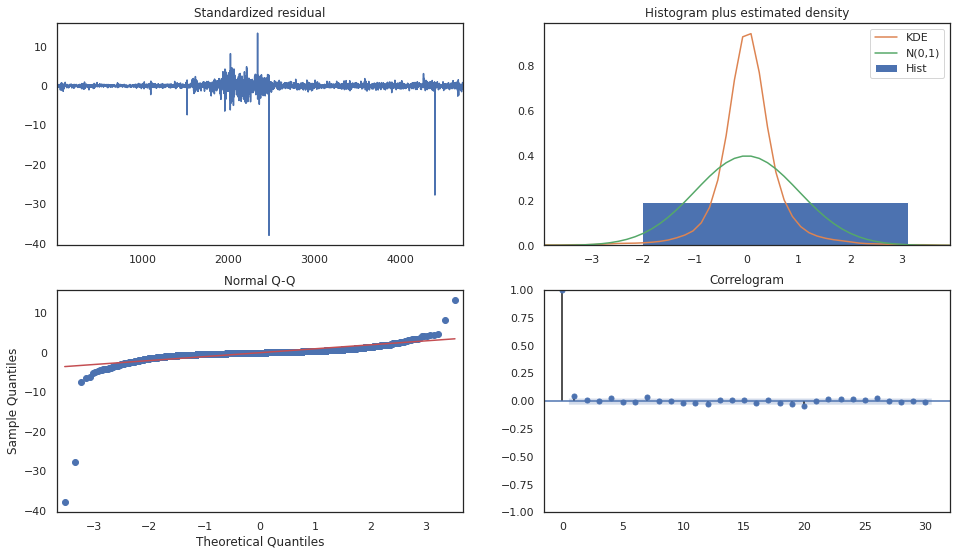

In [ ]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)

<font size="+3" color='#780404'><b> AUTO-ARIMA Model </b></font>

In [ ]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=45769.461, Time=7.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45860.449, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45799.168, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=45797.991, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45858.618, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=45792.034, Time=7.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=45784.512, Time=9.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=45769.033, Time=15.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=45777.210, Time=4.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=45775.336, Time=10.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=12.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=45768.822, Time=4.99 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=45781.075, Time=3.19 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=45769.990, Time=10.17 sec
 ARIMA(1,1,4)(0,0,0)[

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4729
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -22877.483
Date:                Sun, 06 Nov 2022   AIC                          45766.967
Time:                        13:42:38   BIC                          45805.734
Sample:                             0   HQIC                         45780.593
                               - 4729                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1585      0.056     20.777      0.000       1.049       1.268
ar.L2         -0.7675      0.051    -15.118      0.000      -0.867      -0.668
ma.L1         -1.0462      0.056    -18.550      0.000      -1.157      -0.936
ma.L2          0.6411      0.047     13.682      0.000       0.549       0.733
ma.L3          0.0375      0.013      2.876      0.004       0.012       0.063
sigma2       933.9666      1.503    621.538      0.000     931.021     936.912
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          53010351.44
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.91   Skew:                           -14.74
Prob(H) (two-sided):                  0.00   Kurtosis:                       520.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

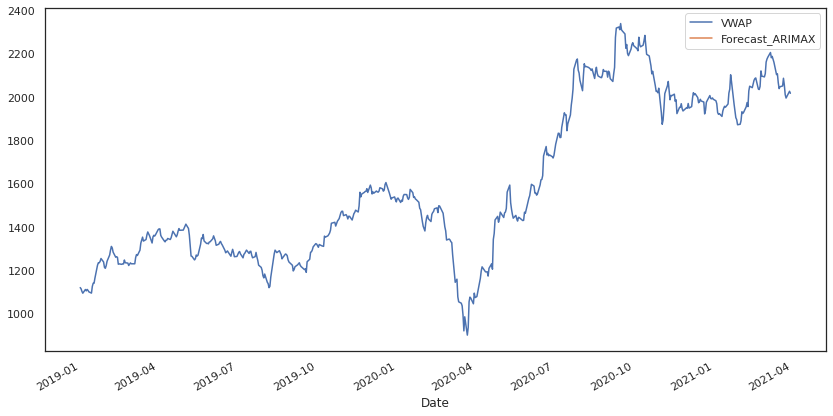

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

ValueError: ignored

The Auto ARIMAX model seems to do a fairly good job in predicting the stock price given data till the previous day. Can other models beat this benchmark?

## Facebook Prophet
Prophet is an open-source time series model developed by Facebook. It was released in early 2017. An exerpt from the homepage:

> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Read more about Prophet: https://facebook.github.io/prophet/

I also shared a starter code [Prophet's Prophecy](https://www.kaggle.com/rohanrao/ashrae-prophet-s-prophecy) for using Prophet in the ASHRAE competition on Kaggle.

Note that the default parameters are used for Prophet. They can be tuned to improve the results.

In [ ]:
from fbprophet import Prophet

model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

In [ ]:
model_fbp.plot_components(forecast)

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))

## LightGBM
Time series problems are popularly converted into a tabular i.i.d. structure and fed into boosting models like [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [XGBoost](https://xgboost.readthedocs.io/en/latest/).

There is loss of information in terms of knowing the order of data points in the time series but it can be circumvented by the datetime features to capture this information to some extent.

Note that the default parameters are used for LightGBM. They can be tuned to improve the results.

In [ ]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.VWAP.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_LightGBM)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))
print("MAE of LightGBM:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_LightGBM))

ARIMA, Prophet and LightGBM models give a fair rmse and mae score. Let's see if deep learning models can do a better job in fitting to our dataset.